In [3]:
from mantaray.core import single_ray, ray_tracing
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

### General Functions

In [31]:
def safe_ray_step(dl, v, fos=1.5):
    return dl/v * fos

def snells_law_bathymetry(phi, old_c, new_c):
    return np.arcsin(np.sin(phi)*new_c/old_c)

def snells_law_shear_current(phi, old_c, v):
    return np.arcsin(np.sin(phi) / (1- v/old_c*np.sin(phi))**2)

def c_shallow(depth, k):
    return np.sqrt(9.8*depth)

def c_deep(depth, k):
    return np.sqrt(9.8/k)

def analytical_ray_trace(xs, y0, phi0, k0, approx_type='deep', mode='shallow_bathymetry', depths=None, v_currents=None):
    '''
    Analytically trace ray at angle phi0 from x axis with wavenumber k0, starting from x0, y0, through points
    xs (where each xs is a point where the ray refracts). Optionally accounts for ray displacement due to shear V
    current, using vs, where each value of vs corresponds to a segment between xs values
    Args:
        xs:
        y0:
        mode (str): Select which version of snell's law is used to compute refraction. Determines which
        optional arguments analytical_ray_trace() uses among depths, v_currents

    '''
    # Initialize Arrays for phis and ys with len = 1 less than xs (don't need final point)
    phis = np.ones(shape=len(xs)-1)
    phis[0] = phi0
    ks = np.ones(shape=len(xs)-1)
    ks[0] = k0
    ky0 = k0 * np.sin(phi0)
    cs = np.ones(shape=len(xs)-1)
    ys = np.ones(shape=len(xs))
    ys[0] = y0

    # If no currents provided, initialize array of 0s
    if v_currents is None:
        v_currents = np.zeros(shape=len(xs)-1)
    
    # If no depth provided, assume deep water flat bathymetry
    if depths is None:
        depths = np.ones(shape=len(xs)-1)*10000

    # set mode for computing refraction and wave speed
    snells_law_func_dict = {'shallow_bathymetry':snells_law_bathymetry, 'shear_currents':snells_law_shear_current}
    snells_law_func = snells_law_func_dict[mode]
    c_func_dict = {'deep':c_deep, 'shallow':c_shallow}
    c_func = c_func_dict[approx_type]
    # Compute initial wave speed
    cs[0] = c_func(depths[0], ks[0])


    #Iterate over each xs aside from last 2, computing phi then ys for next value
    for i, x, in enumerate(xs[:-2]):

        if approx_type == 'shallow':
            cs[i+1] = c_func(depths[i+1], ks[i+1])
        # Compute new phi
        snells_law_args_dict = {'shallow_bathymetry':{'phi':phis[i], 'old_c':cs[i], 'new_c':cs[i+1]},
                           'shear_currents':{'phi':phis[i], 'old_c':cs[i], 'v':v_currents[i+1]}}
        snells_law_args = snells_law_args_dict[mode]
        phis[i+1] = snells_law_func(**snells_law_args)

        # Compute new k and c
        #ks[i+1] = np.tan(phis[i])/np.tan(phis[i+1]) * ks[i]
        #kx_new = -ky0/np.cos(phis[i+1]) * \
        #    (9.8*np.sin(phis[i+1])/ky0 * np.tanh(ky0*depths[i+1] / np.sin(phis[i+1])))**(-0.5) \
        #    + ks[i]*np.cos(ks[i])
        ks[i+1] = ky0 / np.sin(phis[i+1])

        if approx_type == 'deep':
            cs[i+1] = c_func(depths[i+1], ks[i+1])

        # Compute new y value for ray
        ys[i+1] = ys[i] + (np.tan(phis[i]) + v_currents[i] / (cs[i]/2 * np.cos(phis[i]))) * (xs[i+1] - xs[i])
    
    # Compute final y value
    ys[-1] = ys[-2] + (np.tan(phis[-1]) + v_currents[-1] / (cs[-1]/2 * np.cos(phis[-1]))) * (xs[-1] - xs[-2])
    print(v_currents[-1], cs[-1])

    return phis, ys, ks

## Step Function Bathymetry

### Import and Verify Data

Text(0.5, 1.0, 'V Current')

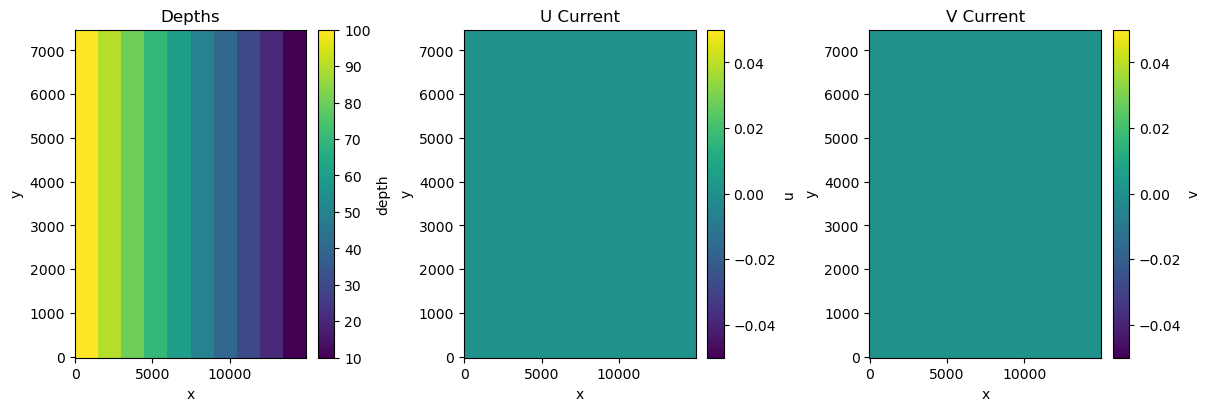

In [45]:
step_bathymetry_path = 'data/step_bathymetry.nc'
null_current_path = 'data/null_current.nc'
step_bathymetry = xr.open_dataset(step_bathymetry_path)
null_current = xr.open_dataset(null_current_path)

# Plot Data to Verify
fig, ax_list = plt.subplots(1, 3, figsize=(12,4), layout='constrained')
step_bathymetry.depth.plot(ax=ax_list[0])
null_current.u.plot(ax=ax_list[1])
null_current.v.plot(ax=ax_list[2])
ax_list[0].set_title('Depths')
ax_list[1].set_title('U Current')
ax_list[2].set_title('V Current')

### Define Ray and Run Ray Trace

In [46]:
# Define Environment Parameters
depth_max = step_bathymetry.depth.max().values
NY, NX = step_bathymetry.depth.shape
dl = np.diff(step_bathymetry.x.values)[0]
depth_levels_raw, depth_indices_raw = np.unique(step_bathymetry.depth.values, return_index=True)
depth_levels = np.flip(depth_levels_raw)
depth_indices = np.flip(depth_indices_raw)
n_shelfs = len(depth_levels)

# Define wave Parameters
k = 2*np.pi/10000 # lambda = 100m
phi0 = np.pi/8
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)
omega = np.sqrt(depth_max*9.8)*k

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [47]:
# Run Single Ray Trace with bathymetry and null current developed above
ray_evolution_raw = single_ray(x0, y0, kx, ky, 1000, 0.5,
                           bathymetry='data/step_bathymetry.nc',
                           current='data/null_current.nc')
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(k = np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
                                         phi = np.arctan2(ray_evolution_raw.ky, ray_evolution_raw.kx))

### Analytically Solve for Ray Path

In [48]:
cs = np.sqrt(9.8*depth_levels)
# Pick x values corresponding to the different boundaries
shelf_edge_xs = step_bathymetry.x.values[depth_indices]
xs_analytical = np.append(shelf_edge_xs, step_bathymetry.x.values[-1]) #Add final right side boundary to xs_analytical
mid_shelf_xs = shelf_edge_xs + np.diff(xs_analytical)/2
xs_analytical[0]=50

phis_analytical, ys_analytical, ks_analytical = analytical_ray_trace(xs_analytical, y0, phi0, k, approx_type='shallow',
                                                      mode='shallow_bathymetry', depths=depth_levels)

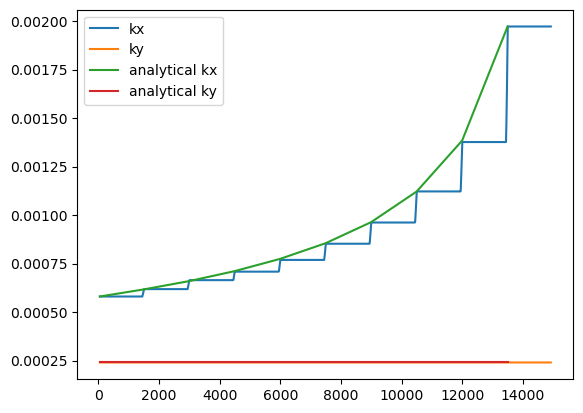

In [49]:
plt.plot(ray_evolution.x, ray_evolution.kx, label='kx')
plt.plot(ray_evolution.x, ray_evolution.ky, label='ky')
plt.plot(xs_analytical[:-1], np.cos(phis_analytical)*ks_analytical, label='analytical kx')
plt.plot(xs_analytical[:-1], np.sin(phis_analytical)*ks_analytical, label='analytical ky')
plt.legend()

In [50]:
xs_analytical

array([   50.,  1500.,  3000.,  4500.,  6000.,  7500.,  9000., 10500.,
       12000., 13500., 14950.])

In [51]:
ys_analytical

array([ 500.        , 1100.60966544, 1685.05348577, 2231.48312094,
       2738.43386639, 3203.99604365, 3625.62300022, 3999.79293847,
       4321.34226635, 4581.89822768, 4764.76486657])

In [52]:
ray_evolution.where((ray_evolution.x >= 2470) & (ray_evolution.x <= 2530), drop=True)

<xarray.Dataset> Size: 280B
Dimensions:  (time_step: 5)
Coordinates:
    time     (time_step) float64 40B 85.5 86.0 86.5 87.0 87.5
    x        (time_step) float64 40B 2.473e+03 2.487e+03 ... 2.515e+03 2.529e+03
    y        (time_step) float64 40B 1.478e+03 1.484e+03 ... 1.495e+03 1.5e+03
Dimensions without coordinates: time_step
Data variables:
    kx       (time_step) float64 40B 0.0006185 0.0006185 ... 0.0006185 0.0006185
    ky       (time_step) float64 40B 0.0002404 0.0002404 ... 0.0002404 0.0002404
    k        (time_step) float64 40B 0.0006636 0.0006636 ... 0.0006636 0.0006636
    phi      (time_step) float64 40B 0.3708 0.3708 0.3708 0.3708 0.3708
Attributes:
    date_created:  2025-04-07 21:46:30.406569

### Compute Ray Trace Error and Plot Rays

In [53]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(data=ray_evolution.phi.values[:-1], coords={'x':ray_evolution.x.values[:-1]})

# Find the difference and percent difference between the analytical and computational ray traces
phi_diffs = np.abs(phis_analytical - ray_angles.sel(x=mid_shelf_xs, method='nearest'))
phi_diffs_percent = phi_diffs / phis_analytical * 100
print('Ray Trace Angle Absolute Difference from Theory:', phi_diffs.values*180/np.pi, 'degrees')
print('Ray Trace Angle Percent Difference from Theory:', phi_diffs_percent.values, '%')

Ray Trace Angle Absolute Difference from Theory: [3.18055468e-15 4.47202873e-02 1.32505614e-01 7.02081558e-02
 1.18256987e-01 5.14965805e-02 2.87014669e-02 4.86800334e-03
 5.35464643e-02 4.05750538e-04] degrees
Ray Trace Angle Percent Difference from Theory: [1.41357986e-14 2.10079250e-01 6.61998623e-01 3.75976182e-01
 6.85825061e-01 3.28006677e-01 2.04916822e-01 4.02342022e-02
 5.43388363e-01 5.83755596e-03] %


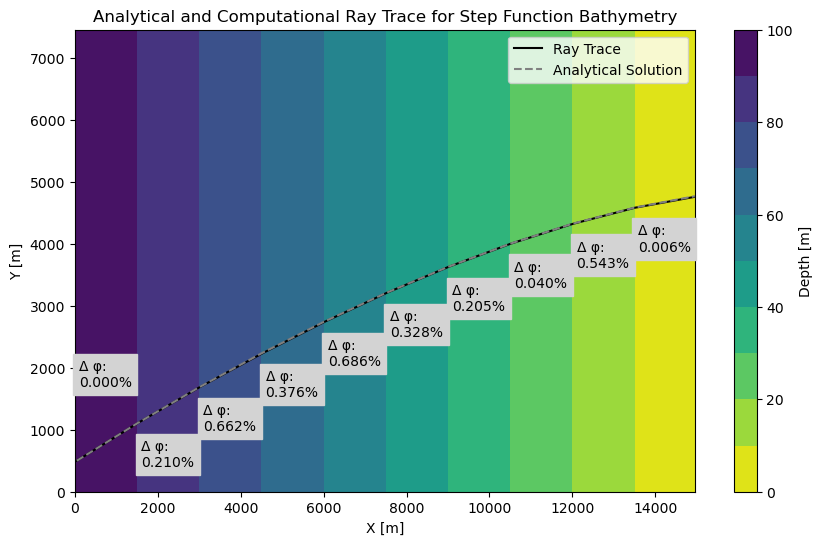

In [60]:
# Plot the Ray Comparisons
fig, ax = plt.subplots(figsize=(10,6))
contours = ax.contourf(step_bathymetry.x, step_bathymetry.y, step_bathymetry.depth, cmap='viridis_r', levels=np.flip(np.concatenate((depth_levels, np.array([0,])))))
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black', label='Ray Trace')
ax.plot(xs_analytical, ys_analytical, marker='', linestyle='dashed', color='grey', label='Analytical Solution')
for i, pcent_diff in enumerate(phi_diffs_percent):
    if i == 0:
        ax.text(x=mid_shelf_xs[i] - 650, y=ys_analytical[i]+1200, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
        continue
    ax.text(x=mid_shelf_xs[i] - 650, y=ys_analytical[i]-700, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
ax.legend()
ax.set_title(label='Analytical and Computational Ray Trace for Step Function Bathymetry')
ax.set_xlabel(xlabel='X [m]')
ax.set_ylabel(ylabel='Y [m]')
cax = fig.colorbar(contours, label='Depth [m]')

Snell's Law (For Bathymetry Only):

$\frac{sin(\phi_1)}{sin(\phi_2)} = \frac{c_1}{c_2} = \frac{|\vec{K_2}|}{|\vec{K_1}|}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ and $c_2$ are the phase speeds of the wave before and after crossing the interface, and $\vec{K_1}$ and $\vec{K_2}$ are the wavenumbers of the incident and transmitted waves, respectively.

In the shallow water approximation, $c = \sqrt{g d}$, where g is the acceleration of gravity and d is the depth of the wave.

## Shear Current

### Import and Verify Data

Text(0.5, 1.0, 'V Current')

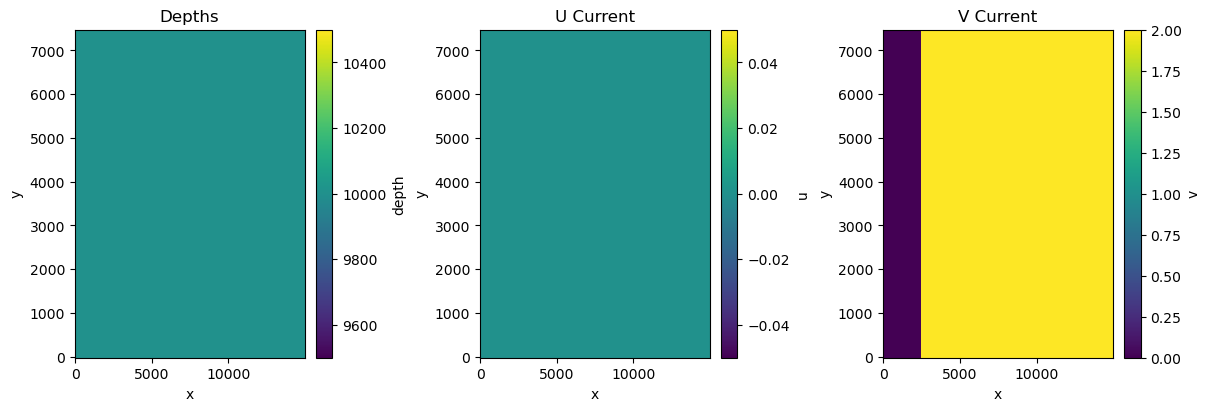

In [32]:
deep_flat_bathymetry_path = 'data/deep_water_flat_bathymetry.nc'
shear_current_path = 'data/shear_current_2v.nc'
deep_flat_bathymetry = xr.open_dataset(deep_flat_bathymetry_path)
shear_current = xr.open_dataset(shear_current_path)

# Plot Data to Verify
fig, ax_list = plt.subplots(1, 3, figsize=(12,4), layout='constrained')
deep_flat_bathymetry.depth.plot(ax=ax_list[0])
shear_current.u.plot(ax=ax_list[1])
shear_current.v.plot(ax=ax_list[2])
ax_list[0].set_title('Depths')
ax_list[1].set_title('U Current')
ax_list[2].set_title('V Current')

### Define Ray and Run Ray Trace

In [33]:
# Define Environment Parameters

v_currents_raw, v_current_indices = np.unique(shear_current.v.values, return_index=True)
v_currents = v_currents_raw # np.flip only works if currents decrease
v_current_indices = v_current_indices # np.flip only works if currents decrease
n_zones = len(v_currents)

# Define wave number
period = 10
lambda0 = 9.81*period**2/(2*np.pi)
k = 2*np.pi/lambda0 # lambda = 50m
phi0 = 50*np.pi/180 # phi0 = 25 degrees from x axis
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [34]:
v_currents

array([0., 2.])

In [35]:
ray_evolution_raw = single_ray(x0, y0, kx, ky, 40000, 1,
                           bathymetry='data/deep_water_flat_bathymetry.nc',
                           current='data/shear_current_2v.nc')
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(k = np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
                                         phi = np.arctan2(ray_evolution_raw.ky, ray_evolution_raw.kx))

In [36]:
ray_evolution2 = ray_evolution.swap_dims({'time_step':'x'})

### Analytically Solve for Ray Path

In [37]:
c0 = np.sqrt(9.8/k)

# Pick x values corresponding to the different boundaries
zone_edge_xs = shear_current.x.values[v_current_indices]
xs_analytical = np.append(zone_edge_xs, shear_current.x.values[-1]) #Add final right side boundary to xs_analytical
mid_zone_xs = zone_edge_xs + np.diff(xs_analytical)/2
xs_analytical[0] = 50

phis_analytical, ys_analytical, ks_analytical = analytical_ray_trace(xs_analytical, y0, phi0, k, approx_type='deep',
                                                      mode='shear_currents', v_currents=v_currents)

2.0 17.30402273210242


In [38]:
xs_analytical

array([   50.,  2500., 14950.])

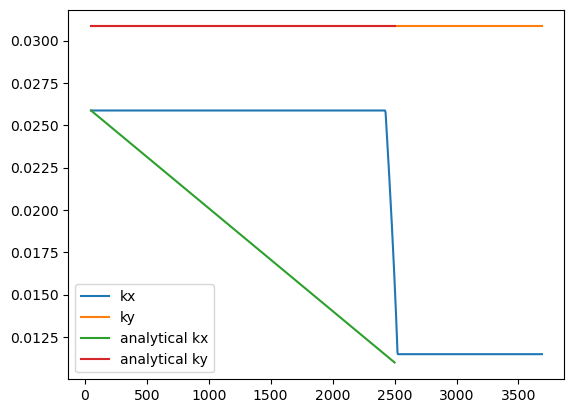

In [39]:
plt.plot(ray_evolution.x, ray_evolution.kx, label='kx')
plt.plot(ray_evolution.x, ray_evolution.ky, label='ky')
plt.plot(xs_analytical[:-1], np.cos(phis_analytical)*ks_analytical, label='analytical kx')
plt.plot(xs_analytical[:-1], np.sin(phis_analytical)*ks_analytical, label='analytical ky')
#plt.plot(ray_evolution.x, ray_evolution.k, label='k')
#plt.plot(xs_analytical[:-1], ks_analytical, label='analytical k')
plt.legend()
#plt.ylim(0.68, 0.72)

In [40]:
phis_analytical

array([0.87266463, 1.22829424])

### Compute Ray Trace Error and Plot Rays

In [41]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(data=ray_evolution.phi.values[:-1], coords={'x':ray_evolution.x.values[:-1]})

# Find the difference and percent difference between the analytical and computational ray traces
phi_diffs = np.abs(phis_analytical - ray_angles.sel(x=mid_zone_xs, method='nearest'))
phi_diffs_percent = phi_diffs / phis_analytical * 100
print('Ray Trace Angle Absolute Difference from Theory:', phi_diffs.values*180/np.pi, 'degrees')
print('Ray Trace Angle Percent Difference from Theory:', phi_diffs_percent.values, '%')

Ray Trace Angle Absolute Difference from Theory: [0.         0.80306527] degrees
Ray Trace Angle Percent Difference from Theory: [0.        1.1411055] %


In [42]:
xs_analytical

array([   50.,  2500., 14950.])

In [43]:
ray_evolution2.where(ray_evolution2.y == ray_evolution2.y.max(), drop=True)

<xarray.Dataset> Size: 56B
Dimensions:  (x: 1)
Coordinates:
    time     (x) float64 8B 884.0
  * x        (x) float64 8B 3.689e+03
    y        (x) float64 8B 7.424e+03
Data variables:
    kx       (x) float64 8B 0.01148
    ky       (x) float64 8B 0.03083
    k        (x) float64 8B 0.0329
    phi      (x) float64 8B 1.214
Attributes:
    date_created:  2025-04-07 23:04:12.918861

In [44]:
trace_travel_angle = np.arctan2(np.diff(ray_evolution.y.values), np.diff(ray_evolution.x.values))
analytical_travel_angle = np.arctan2(np.diff(ys_analytical), np.diff(xs_analytical))
print(analytical_travel_angle)
print(trace_travel_angle[10], trace_travel_angle[-10])
travel_angle_diff = analytical_travel_angle[-1] - trace_travel_angle[-10]
print(travel_angle_diff)

[0.87266463 1.29196089]
0.8726646259971642 1.280632889973939
0.011327997260136113


array([15.60514014, 17.30402273])

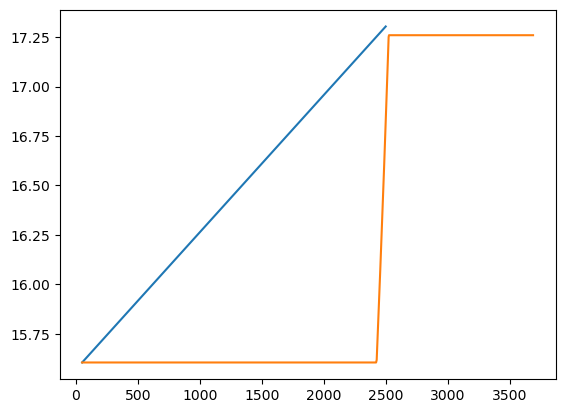

In [45]:
cs_analytical = c_deep(np.zeros_like(ks_analytical), ks_analytical)
cs_trace = c_deep(np.zeros_like(ray_evolution.y), ray_evolution.k)
cs_analytical[-1] = cs_analytical[-1]
plt.plot(xs_analytical[:-1], cs_analytical)
plt.plot(ray_evolution.x, cs_trace)
cs_analytical

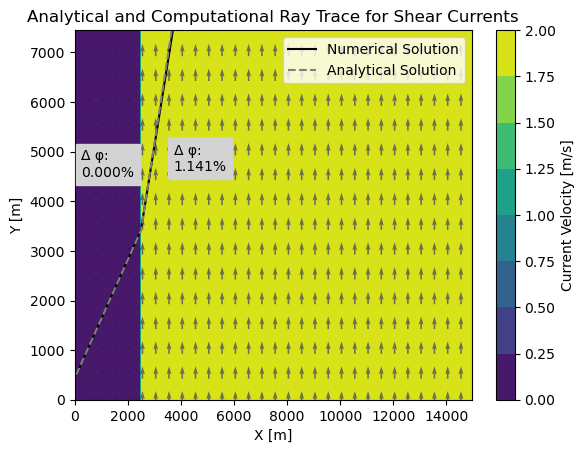

In [46]:
# Plot the Ray Comparisons
fig, ax = plt.subplots()
contours = ax.contourf(shear_current.x, shear_current.y, shear_current.v, cmap='viridis')
quiver_shear_currents = shear_current.sel(x=slice(10, None, 10), y=slice(10, None, 10))
ax.quiver(quiver_shear_currents.x, quiver_shear_currents.y, quiver_shear_currents.u, quiver_shear_currents.v, color='navy',
          pivot='middle', width=0.004, alpha=0.5)
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black', label='Numerical Solution')
ax.plot(xs_analytical, ys_analytical, marker='', linestyle='dashed', color='grey', label='Analytical Solution')
for i, pcent_diff in enumerate(phi_diffs_percent):
    if i == 0:
        ax.text(x=mid_zone_xs[i] - 1000, y=ys_analytical[i]+4000, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
        continue
    ax.text(x=mid_zone_xs[i]-5000, y=ys_analytical[i]+1200, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
ax.legend()
ax.set_title(label='Analytical and Computational Ray Trace for Shear Currents')
ax.set_xlabel(xlabel='X [m]')
ax.set_ylabel(ylabel='Y [m]')
cax = fig.colorbar(contours, label='Current Velocity [m/s]')

Snell's Law (For Shear Currents in Deep Water):

$sin(\phi _2) = \frac{sin(\phi _1)}{(1-\frac{V}{c_1} sin(\phi _1))^2}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ is the phase speed of the wave before crossing the interface, and $V$ is the horizontally sheared current. 

In the deep water approximation, $c = \frac{g}{\omega _0} = \sqrt{\frac{g}{|\vec{K}|}}$, where $g$ is the acceleration of gravity, $\omega _0$ is the fundamental frequency of the wave, and $\vec{K}$ is the initial wavenumber.

In [162]:
ray_evolution

<xarray.Dataset> Size: 45kB
Dimensions:  (time_step: 803)
Coordinates:
    time     (time_step) float64 6kB 0.0 10.0 20.0 ... 8e+03 8.01e+03 8.02e+03
    x        (time_step) float64 6kB 50.0 69.07 88.15 ... 1.491e+04 nan
    y        (time_step) float64 6kB 500.0 505.1 510.2 515.3 ... 121.3 115.6 nan
Dimensions without coordinates: time_step
Data variables:
    kx       (time_step) float64 6kB 0.6069 0.6069 0.6069 ... 0.6936 0.6936 nan
    ky       (time_step) float64 6kB 0.1626 0.1626 0.1626 ... 0.1626 0.1626 nan
    k        (time_step) float64 6kB 0.6283 0.6283 0.6283 ... 0.7124 0.7124 nan
    phi      (time_step) float64 6kB 0.2618 0.2618 0.2618 ... 0.2303 0.2303 nan
Attributes:
    date_created:  2025-03-27 15:36:08.704342